# Modelling in v0.3

In [1]:
%matplotlib inline

from __future__ import print_function, division

import os
import numpy as np
import math
import time

from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import MultipleLocator, AutoLocator, AutoMinorLocator
from matplotlib import gridspec
from matplotlib import cm

import xpsi

from xpsi.global_imports import _c, _G, _M_s, _dpr, gravradius, _csq, _km, _M_s, _2pi

/=============================================\
| X-PSI: X-ray Pulse Simulation and Inference |
|---------------------------------------------|
|             Version: 0.3.0-alpha            |
|---------------------------------------------|
|  https://thomasedwardriley.github.io/xpsi/  |
\=============================================/

Imported GetDist version: 0.3.1
Imported nestcheck version: 0.2.0


In [2]:
class CustomData(xpsi.Data):
    """ Custom data container. """
    
    def __init__(self, first, last, counts, phases, exposure_time):
        """
        :param counts: A :class:`numpy.ndarray` of count numbers. The rows of
                       the array must map to a contiguous subset of instrument
                       output channels, with the zeroth row corresponding to
                       the :attr:`first` channel, and the last row
                       corresponding to the channel :attr:`last` minus one.
                       The columns must map to the phases given by
                       :obj:`phases`.
        :param phases: A :class:`numpy.ndarray` of phase *edges* of intervals
                       in which the *synthetic* photons arrive.
        :param exposure_time: The total exposure time in seconds.
        
        """
        # Execute parent initialisation code
        super(CustomData, self).__init__(first, last)

        if not isinstance(counts, np.ndarray):
            raise TypeError('Counts object is not a ``numpy.ndarray``.')
        else:
            self._counts = counts

        if self._counts.shape[0] != self._last - self._first:
            raise ValueError('The number of rows must be compatible '
                                 'with the first and last output channel '
                                 'numbers.')

        if not isinstance(phases, np.ndarray):
            raise TypeError('Phases object is not a ``numpy.ndarray``.')
        else:
            self._phases = phases

        self._exposure_time = exposure_time

    @property
    def exposure_time(self):
        """ Get the total exposure time in seconds. """
        return self._exposure_time

    @property
    def counts(self):
        """ Get the photon count data. """
        return self._counts

    @property
    def phases(self):
        """ Get the phases. """
        return self._phases

    @classmethod
    def from_txt(cls, path, **kwargs):
        """ Constructor which loads photon data from a .txt file.
        :param str path: Path to .txt file which is converted into a
                         two-dimensional :class:`numpy.ndarray`.
        """
        try:
            data = np.loadtxt(path, dtype=np.double)
        except (OSError, IOError, TypeError, ValueError):
            print('Data file could not be loaded.')
            raise

        first = 0; last = 181

        phases = np.linspace(0.0, 1.0, 33)

        return cls(first, last, data, phases, **kwargs)

Let us load a synthetic data set that we generated in advance, and know the fictitious exposure time for.

In [3]:
data = CustomData.from_txt('../data/synthetic_realisation.dat',
                           exposure_time = 984307.6661)

Let's take a look at the data that we aim to model. First we define some settings and helper functions:

In [4]:
rcParams['text.usetex'] = False
rcParams['font.size'] = 14.0

def veneer(x, y, axes, lw=1.0, length=8):
    """ Make the plots a little more aesthetically pleasing. """
    if x is not None:
        if x[1] is not None:
            axes.xaxis.set_major_locator(MultipleLocator(x[1]))
        if x[0] is not None:
            axes.xaxis.set_minor_locator(MultipleLocator(x[0]))
    else:
        axes.xaxis.set_major_locator(AutoLocator())
        axes.xaxis.set_minor_locator(AutoMinorLocator())
        
    if y is not None:
        if y[1] is not None:
            axes.yaxis.set_major_locator(MultipleLocator(y[1]))
        if y[0] is not None:
            axes.yaxis.set_minor_locator(MultipleLocator(y[0]))
    else:
        axes.yaxis.set_major_locator(AutoLocator())
        axes.yaxis.set_minor_locator(AutoMinorLocator())
        
    axes.tick_params(which='major', colors='black', length=length, width=lw)
    axes.tick_params(which='minor', colors='black', length=int(length/2), width=lw)
    plt.setp(axes.spines.values(), linewidth=lw, color='black')

def plot_one_pulse(pulse, x, label=r'Counts'):
    """ Plot a pulse resolved over a single rotational cycle. """
    
    fig = plt.figure(figsize = (7,7))

    gs = gridspec.GridSpec(1, 2, width_ratios=[50,1])
    ax = plt.subplot(gs[0])
    ax_cb = plt.subplot(gs[1])

    profile = ax.pcolormesh(x,
                             np.arange(data.channel_range[1])+20,
                             pulse,
                             cmap = cm.magma,
                             linewidth = 0,
                             rasterized = True)

    profile.set_edgecolor('face')

    ax.set_xlim([0.0, 1.0])
    ax.set_yscale('log')
    ax.set_ylabel(r'Channel')
    ax.set_xlabel(r'Phase')

    cb = plt.colorbar(profile,
                      cax = ax_cb)

    cb.set_label(label=label, labelpad=25)
    cb.solids.set_edgecolor('face')

    veneer((0.05, 0.2), (None, None), ax)

    plt.subplots_adjust(wspace = 0.025)

Now for the data:

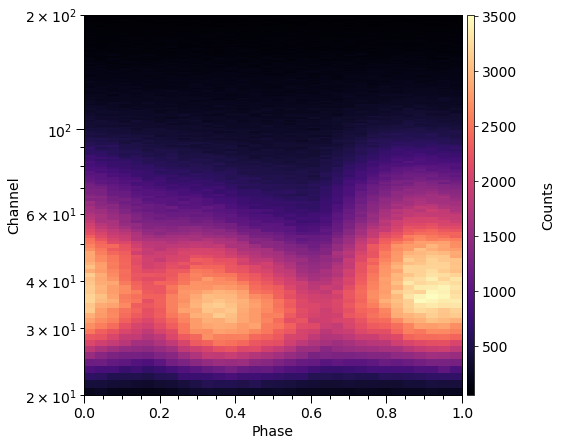

In [5]:
plot_one_pulse(data.counts, data.phases)

### Instrument

We require a model instrument object to transform incident specific flux pulses into a form which enters directly in the sampling distribution of the data.

In [6]:
class CustomInstrument(xpsi.Instrument):
    """ A model of the NICER telescope response.
    
    """
    def __init__(self, channels, channel_edges, *args):
        super(CustomInstrument, self).__init__(*args)
        self._channels = channels
        self._channel_edges = channel_edges

    @property
    def channels(self):
        return self._channels

    @property
    def channel_edges(self):
        """ Get the channel edges. """
        return self._channel_edges
    
    def __call__(self, signal, *args):
        """ Overwrite base just to show it is possible.
        
        We loaded only a submatrix of the total instrument response
        matrix into memory, so here we can simplify the method in the
        base class.
        
        """

        matrix = self.construct_matrix()

        self._folded_signal = np.dot(matrix, signal)

        return self._folded_signal

    @classmethod
    def from_response_files(cls, ARF, RMF, max_input, min_input=0,
                            channel_edges=None):
        """ Constructor which converts response files into :class:`numpy.ndarray`s.
        :param str ARF: Path to ARF which is compatible with
                                :func:`numpy.loadtxt`.
        :param str RMF: Path to RMF which is compatible with
                                :func:`numpy.loadtxt`.
        :param str channel_edges: Optional path to edges which is compatible with
                                  :func:`numpy.loadtxt`.
        """

        if min_input != 0:
            min_input = int(min_input)

        max_input = int(max_input)

        try:
            ARF = np.loadtxt(ARF, dtype=np.double, skiprows=3)
            RMF = np.loadtxt(RMF, dtype=np.double)
            if channel_edges:
                channel_edges = np.loadtxt(channel_edges, dtype=np.double, skiprows=3)[:,1:]
        except:
            print('A file could not be loaded.')
            raise
            
        matrix = np.ascontiguousarray(RMF[min_input:max_input,20:201].T, dtype=np.double)

        edges = np.zeros(ARF[min_input:max_input,3].shape[0]+1, dtype=np.double)

        edges[0] = ARF[min_input,1]; edges[1:] = ARF[min_input:max_input,2]

        for i in range(matrix.shape[0]):
            matrix[i,:] *= ARF[min_input:max_input,3]

        channels = np.arange(20, 201)

        return cls(channels, channel_edges[20:202,-2], matrix, edges)

Let's construct an instance.

In [7]:
NICER = CustomInstrument.from_response_files(ARF = '../model_data/nicer_v1.01_arf.txt',
                                             RMF = '../model_data/nicer_v1.01_rmf_matrix.txt',
                                             max_input = 500,
                                             min_input = 0,
                                             channel_edges = '../model_data/nicer_v1.01_rmf_energymap.txt')

No parameters supplied... empty subspace created.


The NICER ``v1.01`` response matrix:

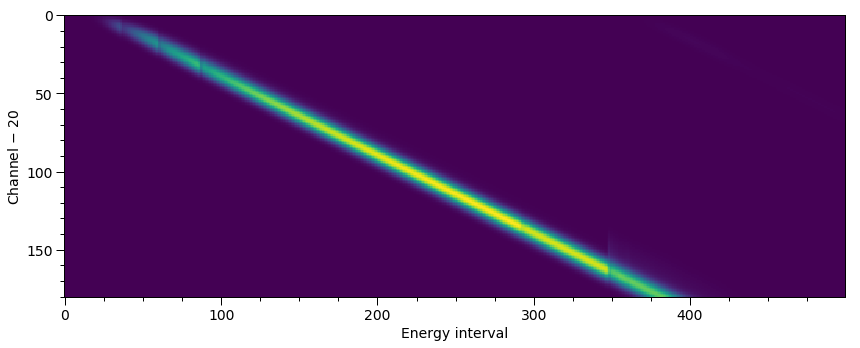

In [8]:
fig = plt.figure(figsize = (14,7))

ax = fig.add_subplot(111)
veneer((25, 100), (10, 50), ax)

_ = ax.imshow(NICER.matrix,
              cmap = cm.viridis,
              rasterized = True)

ax.set_ylabel('Channel $-\;20$')
_ = ax.set_xlabel('Energy interval')

Summed over channel subset $[20,200]$:

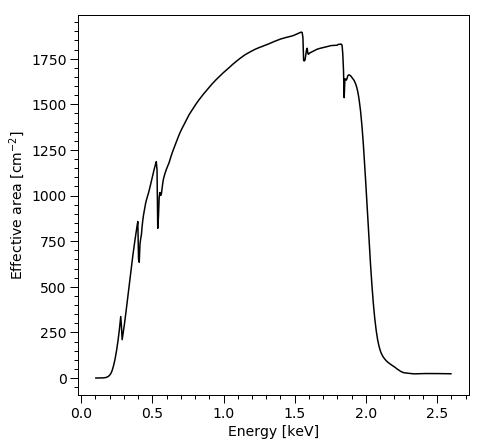

In [9]:
fig = plt.figure(figsize = (7,7))

ax = fig.add_subplot(111)
veneer((0.1, 0.5), (50,250), ax)

ax.plot((NICER.energy_edges[:-1]+NICER.energy_edges[1:])/2.0, np.sum(NICER.matrix, axis=0), 'k-')

ax.set_ylabel('Effective area [cm$^{-2}$]')
_ = ax.set_xlabel('Energy [keV]')

### Pulse

In [10]:
from xpsi.likelihoods.default_background_marginalisation import eval_marginal_likelihood
from xpsi.likelihoods.default_background_marginalisation import precomputation

class CustomPulse(xpsi.Pulse):
    """ A custom calculation of the logarithm of the likelihood.
    We extend the :class:`xpsi.Pulse.Pulse` class to make it callable.
    We overwrite the body of the __call__ method. The docstring for the
    abstract method is copied.
    """

    def __init__(self, workspace_intervals = 1000, epsabs = 0, epsrel = 1.0e-8,
                 epsilon = 1.0e-3, sigmas = 10.0, **kwargs):
        """ Perform precomputation. """

        super(CustomPulse, self).__init__(**kwargs)

        try:
            self._precomp = precomputation(self._data.counts.astype(np.int32))
        except AttributeError:
            print('Warning: No data... can synthesise data but cannot evaluate a '
                  'likelihood function.')
        else:
            self._workspace_intervals = workspace_intervals
            self._epsabs = epsabs
            self._epsrel = epsrel
            self._epsilon = epsilon
            self._sigmas = sigmas

    def __call__(self, phase_shifts, **kwargs):
        self.shift = np.array(phase_shifts)

        self.loglikelihood, self.expected_counts, self.background_signal = \
                eval_marginal_likelihood(self._data.exposure_time,
                                          self._data.phases,
                                          self._data.counts,
                                          self._pulse,
                                          self._phases[0],
                                          self._shift,
                                          self._precomp,
                                          self._workspace_intervals,
                                          self._epsabs,
                                          self._epsrel,
                                          self._epsilon,
                                          self._sigmas,
                                          kwargs.get('llzero'))

In the first part of this notebook we define a *marginal* likelihood function. That is, instead of invoking the true background model that in this case is known to us, we invoke a default treatment whereby we marginalise over a set of channel-by-channel background count-rate parameters instead.

We wrote our ``__call__`` method as a wrapper for a extension module to improve speed.  The source code for the simpler case of parameter estimation when the background model is known (see path ``xpsi/examples/true_background``). In general, if you wish to change the model for likelihood evaluation given pulses, you can archive the Cython extensions in, e.g., the ``xpsi/likelihoods``, and compile these when X-PSI is compiled and installed (by editing the ``setup.py`` script). Alternatively, you can compile your extension elsewhere and call those compiled binaries from your custom class derived from ``xpsi.Pulse``.

Let's construct and instantiate a ``xpsi.Pulse`` object. We must accept phase shift parameters, which are a *fast* nuisance parameter; this detailed in the docstring of ``xpsi.Pulse``. The bounds of the background parameter have already been specified above.

In [11]:
pulse = CustomPulse(data = data,
                    instrument = NICER,
                    background = None,
                    interstellar = None,
                    energies_per_interval = 0.5,
                    default_energy_spacing = 'logspace',
                    fast_rel_energies_per_interval = 0.5,
                    workspace_intervals = 1000,
                    adaptive_energies = False,
                    store = True,
                    epsrel = 1.0e-8,
                    epsilon = 1.0e-3,
                    sigmas = 10.0)

### Constructing a star

We now need to build our star. The basic units for building a star are:

* the [Spacetime](spacetime.rst#xpsi.Spacetime.Spacetime) class;
* the [Photosphere](photosphere.rst#xpsi.Photosphere.Photosphere) class;
* the [HotRegion](hotregion.rst#xpsi.HotRegion.HotRegion) class;
* the [Elsewhere](elsewhere.rst#xpsi.Elsewhere.Elsewhere) class;
* and four low-level user-modifiable routines for evaluation of a parametrised specific intensity model.

For this demonstration we will assume that the surface radiation field *elsewhere* (other than the hot regions) can be ignored in the soft X-ray regime our model instrument is sensitive to. For more advanced modelling, we can simply write custom *derived* classes, and instantiate those derived classes to construct objects for our model. In particular, a common pattern will be to subclass the [HotRegion](hotregion.rst#xpsi.HotRegion.HotRegion) class. Let's start with the [Spacetime](spacetime.rst#xpsi.Spacetime.Spacetime) class.

#### The ambient spacetime

We did not overwrite [Spacetime.update](spacetime.rst#xpsi.Spacetime.Spacetime.update) in our custom derived class, and thus did not add free parameters, so we set the keyword ``num_params`` to four, and define the bounds. We will assume a coordinate rotation frequency based on timing analyses of 300.0 Hz; we thus *fix* the coordinate rotation frequency of the star. 

In [12]:
spacetime = xpsi.Spacetime.fixed_spin(300.0)

Configuring default bounds with fixed spin...
Creating parameter:
    > Named "frequency" with fixed value 3.000e+02.
    > Spin frequency [Hz].


Creating parameter:
    > Named "mass" with bounds [1.000e+00, 3.000e+00].
    > Gravitational masses [solar masses].


Creating parameter:
    > Named "radius" with bounds [1.477e+00, 1.600e+01].
    > Coordinate equatorial radius [km].


Creating parameter:
    > Named "distance" with bounds [5.000e-02, 2.000e+00].
    > Earth distance [kpc].


Creating parameter:
    > Named "inclination" with bounds [0.000e+00, 3.142e+00].
    > Earth inclination to rotation axis [radians].


Spacetime configured.


In [13]:
for p in spacetime:
    print(p)

Gravitational masses [solar masses].
Coordinate equatorial radius [km].
Earth distance [kpc].
Earth inclination to rotation axis [radians].


Alternatively we can specify bounds manually for the free parameters, and give the spin frequency.

In [14]:
bounds = dict(distance = (0.1, 1.0),                     # (Earth) distance
                mass = (1.0, 3.0),                       # mass
                radius = (3.0 * gravradius(1.0), 16.0),  # equatorial radius
                inclination = (0.001, math.pi/2.0))      # (Earth) inclination to rotation axis

spacetime = xpsi.Spacetime(bounds=bounds, values=dict(frequency=300.0))

Creating parameter:
    > Named "frequency" with fixed value 3.000e+02.
    > Spin frequency [Hz].


Creating parameter:
    > Named "mass" with bounds [1.000e+00, 3.000e+00].
    > Gravitational masses [solar masses].


Creating parameter:
    > Named "radius" with bounds [4.430e+00, 1.600e+01].
    > Coordinate equatorial radius [km].


Creating parameter:
    > Named "distance" with bounds [1.000e-01, 1.000e+00].
    > Earth distance [kpc].


Creating parameter:
    > Named "inclination" with bounds [1.000e-03, 1.571e+00].
    > Earth inclination to rotation axis [radians].




#### The photosphere and its constituent regions

It is not necessary for us to write a custom derived class for the photosphere object, so we will simply instantiate a [Photosphere](photosphere.rst#xpsi.Photosphere.Photosphere) object. However, we first need an instance of [HotRegion](hotregion.rst#xpsi.HotRegion.HotRegion) to instantiate the photosphere, and we need to implement a low-level parametrised model for the specific intensity emergent from the photosphere in a local comoving frame.

The following is the contents of the ``hot_radiation_field.pxd`` file which the X-PSI integrators use as the header file for including other C functions in the package.

```cython
cdef double eval_hotRadField(size_t THREAD,
                             double E,
                             double mu,
                             const double *const VEC,
                             void *const data) nogil

cdef double eval_hotRadField_norm() nogil

cdef void* init_hotRadField(size_t numThreads) nogil

cdef int free_hotRadField(size_t numThreads, void *const data) nogil
```

**You are free to modify these functions in the associated** ``hot_radiation_field.pyx`` **implementation file, and you have almost complete control over the function bodies, but not the signatures.** By default the package includes an isotropic blackbody model:

```cython
#cython: cdivision=True
#cython: boundscheck=False
#cython: nonecheck=False
#cython: wraparound=False

from libc.math cimport exp

cdef int SUCCESS = 0

cdef double erg = 1.0e-7
cdef double Planck_dist_const = 5.040366110812353e22
    
#----------------------------------------------------------------------->>>
# >>> User modifiable functions.
# >>> Note that the user is entirely free to wrap thread-safe and
# ... non-parallel external C routines from an external library.
# >>> Thus the bodies of the following need not be written explicitly in
# ... the Cython language.
#----------------------------------------------------------------------->>>
cdef void* init_hotRadField(size_t numThreads) nogil:
    # This function must match the free management routine free_hotRadField()
    # in terms of freeing dynamically allocated memory. This is entirely
    # the user's responsibility to manage.

    # Return NULL if dynamic memory is not required for the model.
    return NULL

cdef int free_hotRadField(size_t numThreads, void *const data) nogil:
    # This function must match the initialisation routine init_hotRadField()
    # in terms of freeing dynamically allocated memory. This is entirely
    # the user's responsibility to manage.
    # The void pointer must be appropriately cast before memory is freed --
    # only the user can know this at compile time.
    # Just use free(<void*> data) iff no memory was dynamically
    # allocated in the function:
    #   init_local_hotRadField()
    # because data is expected to be NULL in this case

    #printf("\nNo data to be freed.")

    return SUCCESS

cdef double eval_hotRadField(size_t THREAD,
                             double E,
                             double mu,
                             const double *const VEC,
                             void *const data) nogil:
    
    cdef double temp = k_B_over_keV * pow(10.0, VEC[0])
    
    return E * E * E / ( exp(E / temp) - 1.0 )

cdef double eval_hotRadField_norm() nogil:
    # Surface radiation field normalisation which is independent of the
    # parameters of the parametrised model, i.e. cell properties, energy,
    # and angle.
    # Writing the normalisation here reduces the number of operations required
    # during integration.

    return erg * Planck_dist_const
```

In most use-cases we need to modify these functions to enable handling of the numerical atmosphere data. An extension for such a case may be found as an [example](extensions.rst), which contains that used by [*Riley et al. (2019)*](applications.rst) to implement the ``NSX`` atmosphere computed by Wynn Ho. In general, if you wish to change the model for the parametrised local comoving surface radiation field model, you can archive the extensions in, e.g., the ``xpsi/surface_radiation_field/archive``, and completely replace the contents of ``xpsi/surface_radiation_field/hot_radiation_field.pyx`` when X-PSI is compiled and installed. Alternatively, you can compile your extension elsewhere and link it when X-PSI is installed (by editing the ``setup.py`` script), `cimporting` or `extern`ing from the appropriate `.pxd` header file(s), and calling those precompiled binaries from the functions declared in the ``xpsi/surface_radiation_field/hot_radiation_field.pxd`` header.

Since the atmospheric local comoving effective temperature is uniform everywhere within the hot region boundary, we can use the default value of the ``symmetry`` keyword, ``True``. All other arguments determine the numerical resolution, and have defaults which have been (somewhat arbitrarily) chosen to be result in a likelihood evaluation time of $\mathcal{O}(1)$ s.

We now instantiate hot region objects. We can find the required and optional parameter names in the class docstring:

In [15]:
xpsi.HotRegion#?

xpsi.HotRegion.HotRegion

The names can also be found as class attributes as follows:

In [16]:
xpsi.HotRegion.required_names

['super_colatitude',
 'super_radius',
 'phase_shift',
 'super_temperature (if no custom specification)']

The condition *if no custom specification* means that this name is required if you do not supply custom parameters for the radiation field in the superseding member of the hot region. If you supply custom parameters, you also need to subclass ``xpsi.HotRegion`` and overwrite the ``__compute_cellParamVecs`` method to handle your parameters.

In [17]:
xpsi.HotRegion.optional_names

['omit_colatitude',
 'omit_radius',
 'omit_azimuth',
 'cede_colatitude',
 'cede_radius',
 'cede_azimuth',
 'cede_temperature']

In [18]:
bounds = dict(super_colatitude = (None, None),
              super_radius = (None, None),
              phase_shift = (None, None),
              super_temperature = (None, None))

# a simple circular, simply-connected spot
primary = xpsi.HotRegion(bounds=bounds,
                            values={}, # no initial values and no derived/fixed
                            symmetry=True,
                            omit=False,
                            cede=False,
                            concentric=False,
                            sqrt_num_cells=32,
                            min_sqrt_num_cells=10,
                            max_sqrt_num_cells=64,
                            num_leaves=100,
                            num_rays=200,
                            do_fast=False,
                            prefix='p') # unique prefix needed because >1 instance

# overlap of an omission region and
# and a radiating super region
secondary = xpsi.HotRegion(bounds=bounds, # can use same bounds
                              values={},  # no initial values and no derived/fixed
                              symmetry=True,
                              omit=False,
                              cede=False,
                              concentric=False,
                              sqrt_num_cells=32,
                              min_sqrt_num_cells=10,
                              max_sqrt_num_cells=100,
                              num_leaves=100,
                              num_rays=200,
                              do_fast=False,
                              is_secondary=True,
                              prefix='s') # unique prefix needed because >1 instance

from xpsi import HotRegions

hot = HotRegions((primary, secondary))

Creating parameter:
    > Named "super_colatitude" with bounds [0.000e+00, 3.142e+00].
    > The colatitude of the centre of the superseding region [radians].


Creating parameter:
    > Named "super_radius" with bounds [0.000e+00, 1.571e+00].
    > The angular radius of the (circular) superseding region [radians].


Creating parameter:
    > Named "phase_shift" with bounds [-5.000e-01, 5.000e-01].
    > The phase of the hot region, a periodic parameter [cycles].


Creating parameter:
    > Named "omit_colatitude" that is derived from ulterior variables.
    > The colatitude of the centre of the omission region [radians].


Creating parameter:
    > Named "omit_radius" with fixed value 0.000e+00.
    > The angular radius of the (circular) omission region [radians].


Creating parameter:
    > Named "omit_azimuth" with fixed value 0.000e+00.
    > The azimuth of the centre of the omission region relative to the
centre of the superseding region [radians].


Creating parameter:
    > Name

Let's check out the hot regions:

In [19]:
hot.objects[0] # 'p'

Free parameters
---------------
p__phase_shift: The phase of the hot region, a periodic parameter [cycles].
p__super_colatitude: The colatitude of the centre of the superseding region [radians].
p__super_radius: The angular radius of the (circular) superseding region [radians].
p__super_temperature: log10(superseding region effective temperature [K]).

Derived/fixed parameters
------------------------
p__cede_colatitude: The colatitude of the centre of the ceding region [radians].
p__cede_radius: The angular radius of the (circular) ceding region [radians].
p__cede_azimuth: The azimuth of the centre of the ceding region relative to the
centre of the superseding region [radians].
p__omit_colatitude: The colatitude of the centre of the omission region [radians].
p__omit_radius: The angular radius of the (circular) omission region [radians].
p__omit_azimuth: The azimuth of the centre of the omission region relative to the
centre of the superseding region [radians].

In [20]:
hot.objects[1] # 's'

Free parameters
---------------
s__phase_shift: The phase of the hot region, a periodic parameter [cycles].
s__super_colatitude: The colatitude of the centre of the superseding region [radians].
s__super_radius: The angular radius of the (circular) superseding region [radians].
s__super_temperature: log10(superseding region effective temperature [K]).

Derived/fixed parameters
------------------------
s__cede_colatitude: The colatitude of the centre of the ceding region [radians].
s__cede_radius: The angular radius of the (circular) ceding region [radians].
s__cede_azimuth: The azimuth of the centre of the ceding region relative to the
centre of the superseding region [radians].
s__omit_colatitude: The colatitude of the centre of the omission region [radians].
s__omit_radius: The angular radius of the (circular) omission region [radians].
s__omit_azimuth: The azimuth of the centre of the omission region relative to the
centre of the superseding region [radians].

A list of names, with the prefix, can also be accessed as follows:

In [21]:
h = hot.objects[0]
h.names

['p__phase_shift',
 'p__super_colatitude',
 'p__super_radius',
 'p__super_temperature',
 'p__cede_colatitude',
 'p__cede_radius',
 'p__cede_azimuth',
 'p__omit_colatitude',
 'p__omit_radius',
 'p__omit_azimuth']

In [22]:
h.prefix

'p'

In [23]:
h.get_param('phase_shift')

The phase of the hot region, a periodic parameter [cycles]

We can now instantitate the photosphere:

In [24]:
photosphere = xpsi.Photosphere(hot = hot, elsewhere = None, value=spacetime['frequency'])

Creating parameter:
    > Named "mode_frequency" with fixed value 1.885e+03.
    > Coordinate frequency of the mode of radiative asymmetry in the
photosphere that is assumed to generate the pulsed signal [Hz].




The photospheric mode frequency in Hz is converted to an angular frequency automatically:

In [25]:
photosphere['mode_frequency'] / xpsi.global_imports._2pi == spacetime['frequency']

True

Note that generally the ``Photosphere`` instance must have a prefix that matches a prefix given to a ``Pulse`` instance to ensure the user achieves what they intend for likelihood evaluation; when the model defines multiple data subsets and thus multiple [Pulse](pulse.rst#xpsi.Pulse.Pulse) instances, tagging the objects in this manner is a safety guard (in particular against inadvertently wasting compute resources sampling a distribution conditional on an unintended model). If there is one ``Photosphere`` and one ``Pulse`` object, the prefixes can simply be none because there is no potential ambiguity.

We do not model the surface radiation field *elsewhere*, and we thus leave the ``elsewhere`` keyword as ``None`` (the default). *Elsewhere* means on the surface, exterior to radiating hot regions that are typically expected to span a smaller angular extent; in the current version, the radiation from *elsewhere*, if explicitly computed is assumed to be time-invariant supposing the hot regions were not present. To account for radiation from *elsewhere*, a time-invariant signal is first computed, meaning an axisymmetric local comoving radiation field is assumed. The time-dependent signals from the hot regions are then computed, and modified by subtracting the specific intensity that would otherwise be generated by the local comoving radiation field from *elsewhere* (i.e., in place of the hot regions).  

#### Star

We can now combine the ambient spacetime, ``spacetime``, and the embedded photosphere, ``photosphere``, into a model star represented by an instance of [Star](star.rst#xpsi.Star.Star). We do not need to extend this class, so we can simply construct and instantiate a star as follows:

In [26]:
star = xpsi.Star(spacetime = spacetime, photospheres = photosphere)

Let's check out the star object, which merged parameter subspaces associated with objects lower in the hierarchy:

In [27]:
star

Free parameters
---------------
mass: Gravitational masses [solar masses].
radius: Coordinate equatorial radius [km].
distance: Earth distance [kpc].
inclination: Earth inclination to rotation axis [radians].
p__phase_shift: The phase of the hot region, a periodic parameter [cycles].
p__super_colatitude: The colatitude of the centre of the superseding region [radians].
p__super_radius: The angular radius of the (circular) superseding region [radians].
p__super_temperature: log10(superseding region effective temperature [K]).
s__phase_shift: The phase of the hot region, a periodic parameter [cycles].
s__super_colatitude: The colatitude of the centre of the superseding region [radians].
s__super_radius: The angular radius of the (circular) superseding region [radians].
s__super_temperature: log10(superseding region effective temperature [K]).

Note that only the free parameters are merged into a subspace higher in the object hierarchy. The reason for this is
that there is not a clear and common pattern (at present) for accessing fixed/derived variables outside of the primary subspace to which they belong. If you try hard enough, of course, you can still get at em'.

### A callable likelihood object

Given the objects constructed above and the relevant pre-compiled low-level code, we can now construct and instantiate a *callable* likelihood object. We do not need extend (via inheritance) the [Likelihood](likelihood.rst#xpsi.Likelihood.Likelihood) class found the source code: this class simply combines all of the model objects defined above, performs some automatic operations given the properties of the those objects, and facilitates communication of those objects when it recieves a call to evaluate the likelihood.

In [28]:
likelihood = xpsi.Likelihood(star = star, pulses = pulse, threads=1, externally_updated=False)

In [29]:
likelihood

Free parameters
---------------
mass: Gravitational masses [solar masses].
radius: Coordinate equatorial radius [km].
distance: Earth distance [kpc].
inclination: Earth inclination to rotation axis [radians].
p__phase_shift: The phase of the hot region, a periodic parameter [cycles].
p__super_colatitude: The colatitude of the centre of the superseding region [radians].
p__super_radius: The angular radius of the (circular) superseding region [radians].
p__super_temperature: log10(superseding region effective temperature [K]).
s__phase_shift: The phase of the hot region, a periodic parameter [cycles].
s__super_colatitude: The colatitude of the centre of the superseding region [radians].
s__super_radius: The angular radius of the (circular) superseding region [radians].
s__super_temperature: log10(superseding region effective temperature [K]).

Let's retrieve the total number of free model parameters merged into the full parameter space:

In [30]:
len(likelihood)

12

We could in principle set the number of OpenMP threads we want to spawn in low-level functions (such as the integrator) which are parallelised, but we will leave it at the default value of ``1`` since we intend to invoke Open MPI and it is best not to experiment with the parallelisation paradigm when preparing a model as a callback for a sampling process.

**Note that if you want to modify the definition of the model parameter space you should restart the process of constructing a** ``likelihood`` **object, intead of manipulating existing objects, for ultimate safety.** (You can also restart the kernel although if this is required it is a bug.)

Let's call the ``likelihood`` object with the true model parameter values that we injected to generate the synthetic data rendered above, omitting background parameters:

In [31]:
p = [1.4,
     12.5,
     0.2,
     1.25,
     0.0,
     1.0,
     0.075,
     6.2,
     0.025,
     math.pi - 1.0,
     0.2,
     6.0]

t = time.time()
ll = likelihood(p, force=True)

print('ll = %.8f; time = %.3f' % (ll, time.time() - t)) # check ll = -26713.6136777 ?

ll = -26713.61367769; time = 1.091


External sampling software will interact with a ``likelihood`` object in this way. That is, it will pass some ordered container of parameter values: a vector. However, this vector will be ignored if the ``likelihood`` instance is told it can safely assume all parameters have been updated *externally*, meaning before the call is placed to ``likelihood.__call__()``. This external update will typically happen during *nested sampling* when a call is placed to a ``prior`` object to inverse sample from the joint prior distribution. Our ``prior`` object can interact with our ``likelihood`` object outside of a sampling process, and thus we can encapsulate a reference to the parameter space in the ``prior`` instance and simply update the parameter values using easier handles (via ``__getitem__`` magic) to conclude an inverse sampled procedure.

### Inspecting functionality

Calling the ``likelihood`` object also modified the ``pulse`` property of the ``photosphere`` object. Let's plot the ``pulse`` by summing the count-rate over output instrument channels. We first define a helper function.

In [30]:
def plot_pulse():
    """ Plot hot region signals before and after telescope operation. """
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111)
    
    ax.set_ylabel('Signal [arbitrary normalisation]')
    ax.set_xlabel('Phase [cycles]')
    
    temp = np.sum(pulse.pulse[0], axis=0)
    ax.plot(pulse.phases[0], temp/np.max(temp), '-', color='k', lw=0.5)
    temp = np.sum(pulse.pulse[1], axis=0)
    ax.plot(pulse.phases[1], temp/np.max(temp), '-', color='r', lw=0.5)
    
    temp = np.sum(photosphere.pulse[0][0], axis=0)
    ax.plot(pulse.phases[0], temp/np.max(temp), 'o-', color='k', lw=0.5, markersize=2)
    temp = np.sum(photosphere.pulse[1][0], axis=0)
    ax.plot(pulse.phases[1], temp/np.max(temp), 'o-', color='r', lw=0.5, markersize=2)
    
    veneer((0.05,0.2), (0.05,0.2), ax)

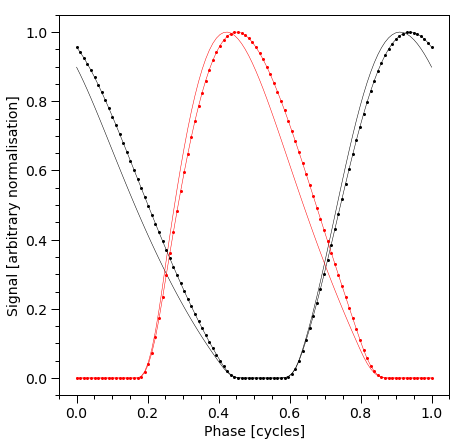

In [31]:
likelihood(p, reinitialise=False)
_ = plot_pulse()

The pulse profiles with markers are the signals incident on the telescope, before operating on them with the response model. The markers, linearly spaced in phase, denote the phase resolution.

The ``likelihood`` object calls the ``star.update`` method which in-turn calls the ``photosphere.embed`` method. The ``likelihood`` object then calls the ``photosphere.integrate`` method, passing the energies stored as the property ``pulse.energies``. We can do this manually if we wish to integrate pulses but not calculate likelihoods. Here we sum over incident specific photon flux pulses as an approximation to integrating over energy. Note that we do not change the ``pulse.pulses`` traced by the solid curves without markers.

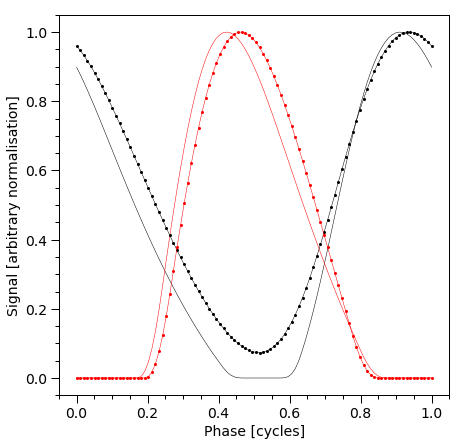

In [32]:
q = [1.4,
     12.5,
     0.2,
     1.0, # lower the Earth inclination
     0.0,
     1.0,
     0.075,
     6.2,
     0.025,
     math.pi - 1.0,
     0.2,
     6.0]

xpsi.ParameterSubspace.ParameterSubspace.__call__(likelihood, q)
star.update()
photosphere.integrate(energies=pulse.default_energies, threads=1)

_ = plot_pulse()

Notice the solid pulses without markers are unchanged from the plot a few cells above, and can be used to guide the eye to the effect of a change in Earth inclination.

Below we print crude representations of the cell meshes spanning each hot region. The elements of a mesh cell-area array which are finite are not all identical: at the boundary of a hot region the proper area elements are smaller because of partial coverage by radiating material. The sum of all finite proper areas effectively equals the total proper area within a hot-region boundary.

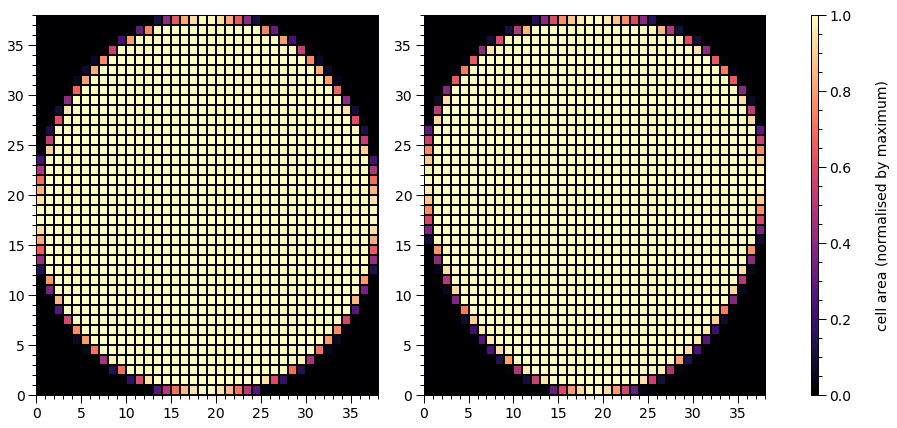

In [33]:
fig = plt.figure(figsize = (14,7))

gs = gridspec.GridSpec(1, 3, width_ratios=[50,50,1], wspace=0.2)
ax = plt.subplot(gs[0])
veneer((1,5), (1, 5), ax)

# primary (lower colatitude) hot region
h = hot.objects[0]
z = h._HotRegion__cellArea[0]/np.max(h._HotRegion__cellArea[0])
patches = plt.pcolormesh(z,
                         vmin = np.min(z),
                         vmax = np.max(z),
                         cmap = cm.magma,
                         linewidth = 1.0,
                         rasterized = True,
                         edgecolor='black')

ax = plt.subplot(gs[1])
veneer((1,5), (1, 5), ax)

# secondary (higher colatitude) hot region
h = hot.objects[1]
z = h._HotRegion__cellArea[0]/np.max(h._HotRegion__cellArea[0])
_ = plt.pcolormesh(z,
                   vmin = np.min(z),
                   vmax = np.max(z),
                   cmap = cm.magma,
                   linewidth = 1.0,
                   rasterized = True,
                   edgecolor='black')

ax_cb = plt.subplot(gs[2])
cb = plt.colorbar(patches,
                  cax = ax_cb,
                  ticks = MultipleLocator(0.2))

cb.set_label(label = r'cell area (normalised by maximum)', labelpad=25)
cb.solids.set_edgecolor('face')

veneer((None, None), (0.05, None), ax_cb)
cb.outline.set_linewidth(1.0)

Note that the lowest colatitude row is at zero on the y-axis.

Let's plot a pulse in two dimensions. Also note that we can interpolate the signal in phase as follows.

In [34]:
from xpsi.tools import phase_interpolator

In [35]:
def plot_2D_pulse(z, x, shift, y, ylabel, num_rotations=5.0, res=5000, cm=cm.viridis):
    """ Helper function to plot a phase-energy pulse.
    
    :param array-like z:
        A pair of *ndarray[m,n]* objects representing the signal at
        *n* phases and *m* values of an energy variable.
        
    :param ndarray[n] x: Phases the signal is resolved at.
        
    :param tuple shift: Hot region phase parameters.
    
    :param ndarray[m] x: Energy values the signal is resolved at.
    
    """
    
    fig = plt.figure(figsize = (12,6))

    gs = gridspec.GridSpec(1, 2, width_ratios=[50,1], wspace=0.025)
    ax = plt.subplot(gs[0])
    ax_cb = plt.subplot(gs[1])

    new_phases = np.linspace(0.0, num_rotations, res)

    interpolated = phase_interpolator.interpolate_pulse(new_phases,
                                                        x,
                                                        z[0], shift[0])
    interpolated += phase_interpolator.interpolate_pulse(new_phases,
                                                         x,
                                                         z[1], shift[1])

    profile = ax.pcolormesh(new_phases,
                             y,
                             interpolated/np.max(interpolated),
                             cmap = cm,
                             linewidth = 0,
                             rasterized = True)

    profile.set_edgecolor('face')

    ax.set_xlim([0.0, 5.0])
    ax.set_yscale('log')
    ax.set_ylabel(ylabel)
    ax.set_xlabel(r'Phase')
    veneer((0.1, 0.5), (None,None), ax)

    cb = plt.colorbar(profile,
                      cax = ax_cb,
                      ticks = MultipleLocator(0.2))

    cb.set_label(label=r'Signal (normalised by maximum)', labelpad=25)
    cb.solids.set_edgecolor('face')

    veneer((None, None), (0.05, None), ax_cb)
    cb.outline.set_linewidth(1.0)

The incident specific flux signal, in units of photons/cm$^{2}$/s/keV as output by the source code, and then normalised to the maximum in specific flux:

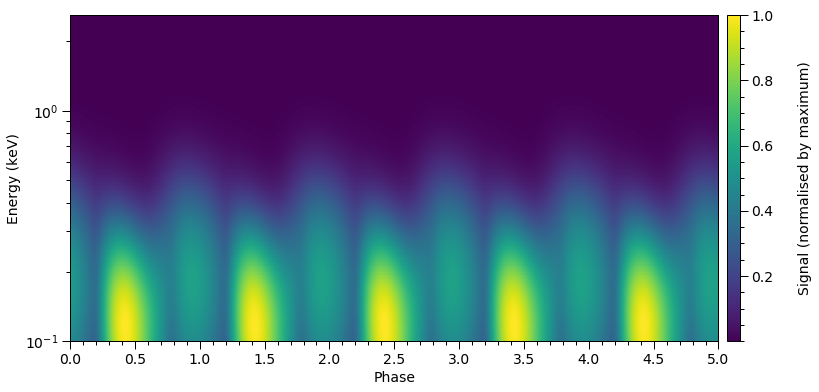

In [36]:
plot_2D_pulse((photosphere.pulse[0][0], photosphere.pulse[1][0]),
              x=pulse.phases[0],
              shift=pulse.shift,
              y=pulse.default_energies,
              ylabel=r'Energy (keV)')

The count rate signal in each channel:

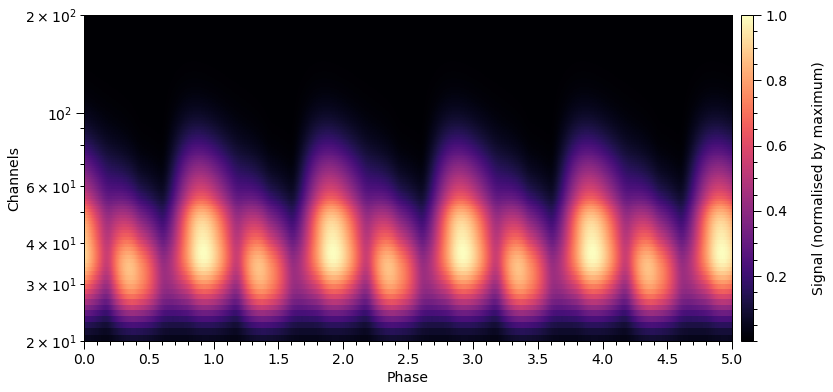

In [37]:
plot_2D_pulse((pulse.pulse[0], pulse.pulse[1]),
              x=pulse.phases[0],
              shift=pulse.shift,
              y=NICER.channels,
              ylabel=r'Channels',
              cm=cm.magma)

Now we use parameter vector ``q``, increase the phase resolution, and plot a single rotational pulse.

In [38]:
for obj in hot.objects:
    obj.set_phases(num_leaves = 1024)
# the current relationship between objects requires that we reinitialise
# if we wish to automatically communicate the update to the phases
_ = likelihood(q, reinitialise = True)

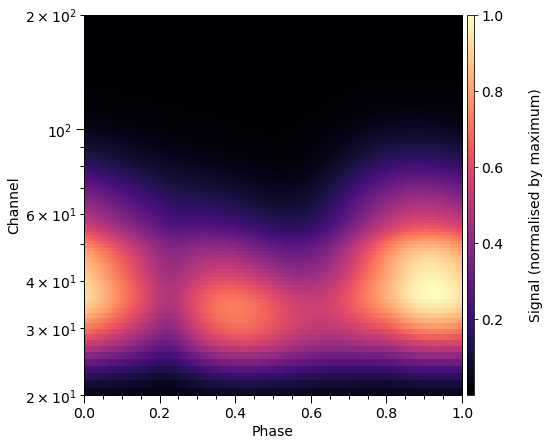

In [39]:
temp = pulse.pulse[0] + pulse.pulse[1]

# the count rate signal is normalised with respect to the global maximum
# over channels and phase of the joint signal from the hot regions
plot_one_pulse(temp/np.max(temp), pulse.phases[0], r'Signal (normalised by maximum)')

Let's iterate over a monotonically increasing set of values of the hot-region angular radius. Note that we use the keyword ``threads`` to directly instruct the low-level routines how many OpenMP threads to spawn to accelerate the computation. Usually the ``likelihood`` object instructs the low-level routines how many threads to spawn, based on it's ``thread`` property:

In [40]:
likelihood.threads

1

Given that we are not currently using the ``likelihood`` object as a callback function passed to posterior sampling software (which parallelises efficiently using Open MPI), we can safely spawn additional worker threads for pulse integration; if likelihood evaluations are parallelised in an Open MPI environment on the other hand, one risks *losing* efficiency by spawning worker threads for likelihood evaluation.

In [41]:
likelihood

Free parameters
---------------
mass: Gravitational masses [solar masses].
radius: Coordinate equatorial radius [km].
distance: Earth distance [kpc].
inclination: Earth inclination to rotation axis [radians].
p__phase_shift: The phase of the hot region, a periodic parameter [cycles].
p__super_colatitude: The colatitude of the centre of the superseding region [radians].
p__super_radius: The angular radius of the (circular) superseding region [radians].
p__super_temperature: log10(superseding region effective temperature [K]).
s__phase_shift: The phase of the hot region, a periodic parameter [cycles].
s__super_colatitude: The colatitude of the centre of the superseding region [radians].
s__super_radius: The angular radius of the (circular) superseding region [radians].
s__super_temperature: log10(superseding region effective temperature [K]).

In [42]:
star()

[1.4, 12.5, 0.2, 1.0, 0.0, 1.0, 0.075, 6.2, 0.025, 2.141592653589793, 0.2, 6.0]

In [43]:
star() == star.vector # possible shortcut to save some characters

True

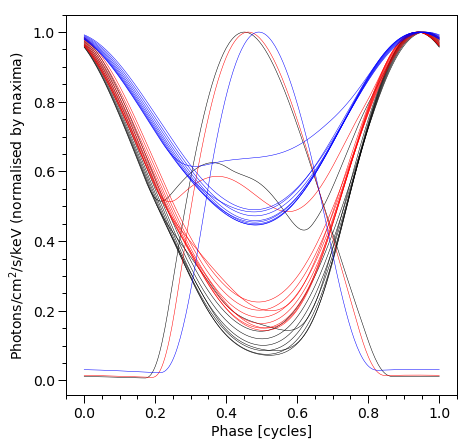

In [44]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
ax.set_ylabel('photons/cm$^2$/s/keV (normalised by maxima)')
ax.set_xlabel('Phase [cycles]')

for obj in hot.objects:
    obj.set_phases(num_leaves = 256)

# let's play with the angular radius of the primary hot region
angular_radii = np.linspace(0.01, 1.0, 10)

q = list(p) # copy

for angular_radius in angular_radii:
    q[6] = angular_radius
    xpsi.ParameterSubspace.ParameterSubspace.__call__(likelihood, q)
    star.update()
    photosphere.integrate(energies=pulse.energies, threads=3)
    temp = np.sum(photosphere.pulse[0][0] + photosphere.pulse[1][0], axis=0)
    _ = ax.plot(hot.phases_in_cycles[0], temp/np.max(temp), 'k-', lw=0.5)

q = list(p)
q[3] = 1.0 # change inclination
    
for angular_radius in angular_radii:
    q[6] = angular_radius
    xpsi.ParameterSubspace.ParameterSubspace.__call__(likelihood, q)
    star.update()
    photosphere.integrate(energies=pulse.energies, threads=3)
    temp = np.sum(photosphere.pulse[0][0] + photosphere.pulse[1][0], axis=0)
    _ = ax.plot(hot.phases_in_cycles[0], temp/np.max(temp), 'r-', lw=0.5)

q = list(p)
q[3] = 0.5

for angular_radius in angular_radii:
    q[6] = angular_radius
    xpsi.ParameterSubspace.ParameterSubspace.__call__(likelihood, q)
    star.update()
    photosphere.integrate(energies=pulse.energies, threads=3)
    temp = np.sum(photosphere.pulse[0][0] + photosphere.pulse[1][0], axis=0)
    _ = ax.plot(hot.phases_in_cycles[0], temp/np.max(temp), 'b-', lw=0.5)
    
veneer((0.05,0.2), (0.05,0.2), ax)

## Prior

Let us now construct a callable object representing a joint prior density distribution on the space $\mathbb{R}^{d}$. We need to extend the base class to implement our distribution, which with respect to some parameters is separable, but for others it is *uniform* on a joint space, and compactly supported according to non-trivial constraint equations.

As an example gravitational mass and equatorial radius: a joint constraint is imposed to assign zero density to stars which are *too* compact: the polar radius, in units of the gravitational radius, of the rotationally deformed stellar 2-surface is too small.

### Custom subclass

In [45]:
from scipy.stats import truncnorm

In [35]:
class CustomPrior(xpsi.Prior):
    """ A custom (joint) prior distribution.
    
    Source: Fictitious
    Model variant: ST-U
        Two single-temperature, simply-connected circular hot regions with
        unshared parameters.
    
    """
    def __init__(self):
        """ Nothing to be done.
        
        A direct reference to the spacetime object could be put here
        for use in __call__:
        
        .. code-block::
        
            self.spacetime = ref
            
        Instead we get a reference to the spacetime object through the
        a reference to a likelihood object which encapsulates a
        reference to the spacetime object.
        
        """
        pass
    
    def __call__(self, p = None):
        """ Evaluate distribution at :obj:`p`.
        
        :param list p: Model parameters values.
        
        :returns: Logarithm of the distribution evaluated at :obj:`p`.
        
        """
        temp = super(CustomPrior, self).__call__(p)
        if not np.isfinite(temp):
            return temp
        
        # based on contemporary EOS theory
        if not self.parameters['radius'] <= 16.0:
            return -np.inf
        
        ref = self.parameters.star.spacetime # shortcut

        # polar radius at photon sphere for ~static star (static ambient spacetime)
        #if R_p < 1.5 / ref.R_r_s:
        #    return -np.inf

        # limit polar radius to try to exclude deflections >= \pi radians
        # due to oblateness this does not quite eliminate all configurations
        # with deflections >= \pi radians
        R_p = 1.0 + ref.epsilon * (-0.788 + 1.030 * ref.zeta)
        if R_p < 1.76 / ref.R_r_s:
            return -np.inf

        mu = math.sqrt(-1.0 / (3.0 * ref.epsilon * (-0.788 + 1.030 * ref.zeta)))

        # 2-surface cross-section have a single maximum in |z|
        # i.e., an elliptical surface; minor effect on support
        if mu < 1.0:
            return -np.inf
        
        ref = self.parameters # redefine shortcut

        # enforce order in hot region colatitude
        if ref['p__super_colatitude'] > ref['s__super_colatitude']:
            return -np.inf

        phi = (ref['p__phase_shift'] - 0.5 - ref['s__phase_shift']) * _2pi

        ang_sep = xpsi.HotRegion.psi(ref['s__super_colatitude'],
                                     phi,
                                     ref['p__super_colatitude'])

        # hot regions cannot overlap
        if ang_sep < ref['p__super_radius'] + ref['s__super_radius']:
            return -np.inf

        return 0.0

    def inverse_sample(self, hypercube=None):
        """ Draw sample uniformly from the distribution via inverse sampling. """
        
        if hypercube is None:
            hypercube = np.random.rand(len(self))
        
        # the base method is useful, so to avoid writing that code again:
        p = super(CustomPrior, self).inverse_sample(hypercube)
        
        # distance
        # this is how you can preserve the cache if you determine that you need to
        # for some reason, or just for safety
        # future note: this could be automated in some way
        self.parameters['distance'] = self.parameters.get_param('distance').cached
        self.parameters['distance'] = truncnorm.ppf(hypercube[0], -2.0, 7.0, loc=0.3, scale=0.1)

        return p

    def transform(self, p):
        """ A transformation for post-processing. """

        p = list(p) # copy
        
        ref = self.parameters.star.spacetime
        # compactness ratio M/R_eq
        
        p += [ref.r_g / ref.R]
        
        ref = self.parameters
        
        if ref['p__phase_shift'] < 0.0:
            tempp = ref['p__phase_shift'] + 1.0
        else:
            tempp = ref['p__phase_shift']
        
        temps = 0.5 + ref['s__phase_shift']
        
        if temps > 1.0:
            temps = temps - 1.0
        
        # phase separation
        if temps >= tempp:
            p += [temps - tempp]
        else:
            p += [1.0 - tempp + temps]

        return p

We can now construct and instantiate a callable ``prior`` object, passing the bounds from the ``likelihood`` object.

In [47]:
prior = CustomPrior()

In [48]:
likelihood.prior = prior

In [49]:
prior() # a parameter vector is already stored

0.0

We also defined a transform method:

In [52]:
prior.transform(p)

[1.4,
 12.5,
 0.2,
 1.25,
 0.0,
 1.0,
 0.075,
 6.2,
 0.025,
 2.141592653589793,
 0.2,
 6.0,
 0.16538200431199998,
 0.525]

The penultimate entry is the compactness ratio M/R_eq, which should have a familar magnitude. The last entry is the phase separation in cycles.

The ``prior.inverse_sample()`` method is required by [MultiNest](https://github.com/farhanferoz/MultiNest) to uniformly sample from the prior distribution and transform it into a posterior distribution. Let's call the method, passing a vector of pseudorandom numbers drawn when each is drawn from a uniform distribution on the interval $[0,1)$:

In [49]:
prior.inverse_sample()

[1.8633486514265678,
 9.661037501215581,
 0.7551032140958538,
 1.4149637622159035,
 0.48837549323127094,
 1.4644823365982507,
 1.1422780288492436,
 4.6539000087368665,
 0.21819317998324583,
 2.1329653117722556,
 0.5263940591688715,
 6.386867181671178]

In principle, inverse sampling from the prior can be used to initialise the ensemble of walkers evolved by [emcee](http://emcee.readthedocs.io/en/latest/). 

### Density and support checking

Let's draw samples from the prior and plot them:

In [53]:
samps, _ = prior.draw(int(1e4))

Drawing samples from the joint prior...
Samples drawn.


In [54]:
def plot_samps(samps, x, y, xlabel, ylabel, s=1.0, color='k', **kwargs):
    """ Plot samples as 2D scatter plot. """
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111)
    ax.scatter(samps[:,x], samps[:,y], s=s, color=color, **kwargs)
    veneer(None, None, ax)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return plt.gca()

Let's first plot the $(M, R_{\rm eq})$ samples: 

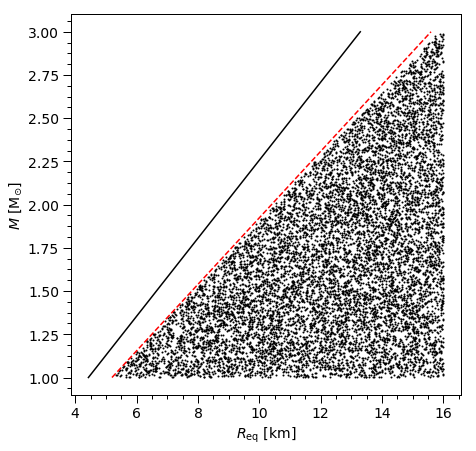

In [55]:
ax = plot_samps(samps,
                likelihood.index('radius'), # we can find the index for __getitem__ magic
                likelihood.index('mass'),
                r'$R_{\rm eq}$ [km]', r'$M$ [M$_{\odot}$]')

# the Schwarzschild photon sphere R_eq = 1.5 x r_s(M)
ax.plot(3.0*gravradius(np.linspace(1.0,3.0,100)), np.linspace(1.0,3.0,100), 'k-')

# R_eq = 1.76 x r_s(M)
_ = ax.plot(2.0*1.76*gravradius(np.linspace(1.0,3.0,100)), np.linspace(1.0,3.0,100), 'r--')

Note that the prior support is defined with a constraint that the polar radius $R_{\rm p}(R_{\rm eq}, M, \Omega)\geq 1.76r_{s}(M)$, which is why there is a region devoid of samples between the prior support and the dashed line $R_{\rm eq} = 1.76r_s(M)$.

Let's now plot the hot region (circular spot) colatitudes:

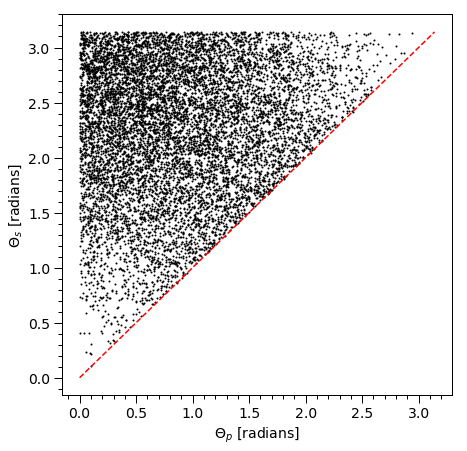

In [56]:
ax = plot_samps(samps,
                likelihood.index('p__super_colatitude'),
                likelihood.index('s__super_colatitude'),
                r'$\Theta_{p}$ [radians]', r'$\Theta_{s}$ [radians]')

# enforce colatitude order to distinguish hot regions as primary and secondary
_ = ax.plot(np.array([0.0,math.pi]), np.array([0.0,math.pi]), 'r--')

Note that the samples, marginalised over other region geometry parameters, are sparser when both hot regions approach the poles because we exclude overlapping configurations from the prior support. This is because the hot regions are by convention defined as disjoint, and cannot merge. If one wanted a more complex hot region, one would not invoke multiple hot regions that are permitted to overlap, but one would instead handle the extra complexity within the ``HotRegion`` class or a subclass.

Let's plot the angular radii of the spots:

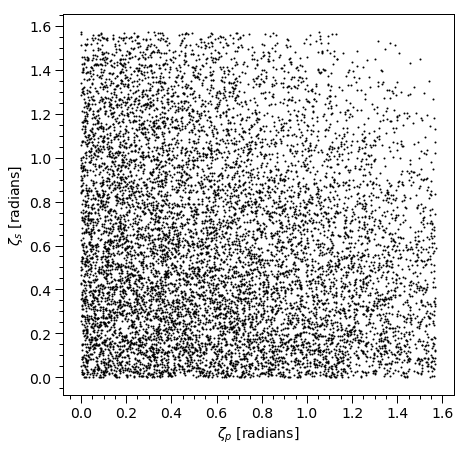

In [57]:
_ = plot_samps(samps,
               likelihood.index('p__super_radius'),
               likelihood.index('s__super_radius'),
               r'$\zeta_{p}$ [radians]',
               r'$\zeta_{s}$ [radians]')

Note that the prior density is greater for hot regions that subtend smaller solid angles at the centre of the star, which also derives from the non-overlapping criterion for prior support.

Finally, let's take a look at the phases:

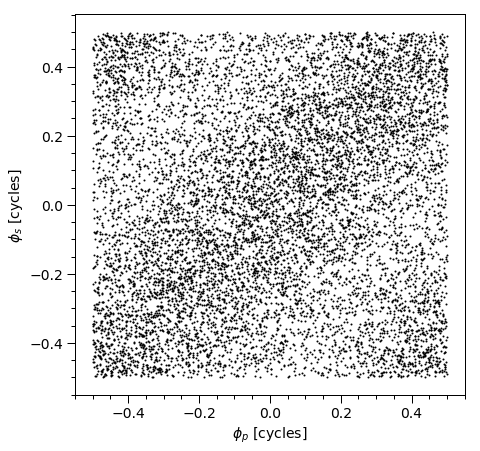

In [58]:
_ = plot_samps(samps,
               likelihood.index('p__phase_shift'),
               likelihood.index('s__phase_shift'),
               r'$\phi_{p}$ [cycles]',
               r'$\phi_{s}$ [cycles]')

Note that again because the hot regions cannot overlap, rarefaction occurs in the vicinity of lines of minimal phase separation. Note that the boundaries are all periodic, so this pattern tesselates. Because we implemented a transformation in our ``CustomPrior`` subclass, we can actually draw the samples and transform them, which is useful in post-processing contexts. We defined the intervals ``[-0.25, 0.75]`` for the inverse sampling so that the posterior mode(s) will not be near a boundary.  The nested sampling algorithm can handle periodic boundaries by defining ``wrapped`` parameters; however, this can be trivially avoided altogether by rough inspection of the phases of the subpulses in the data, which we can see above are at around $-0.1$ and $0.4$ given the respective ground truth phases of $\phi_{p}=0.0$ and $\phi_{s}=0.025$.

Transformations for the purpose of likelihood evaluation must be handled in the ``inverse_sample`` method of an instance of the ``Prior`` class, but additional transformations that *extend* the parameter vector are written in the ``transform`` method.

If we wanted to transform automatically upon drawing the samples, thereby extending the parameter vectors passed to the ``__call__`` method (so be careful with wrap-around indices when evaluating prior support conditions), we would do the following:

In [59]:
samps_plus_transformed, _ = prior.draw(int(1e4), transform=True)

Drawing samples from the joint prior...
Samples drawn.


We defined a transformation from the hot region centre phases to the phase separation:

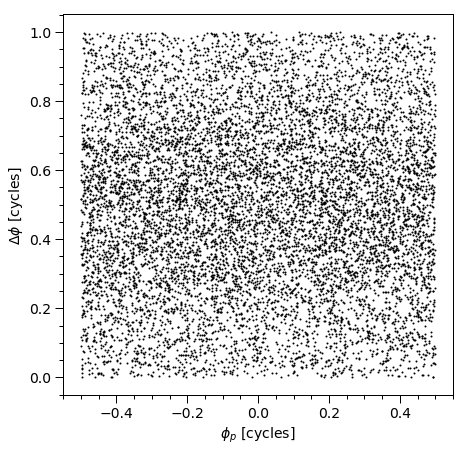

In [60]:
_ = plot_samps(samps_plus_transformed,
               likelihood.index('p__phase_shift'),
               -1,
               r'$\phi_{p}$ [cycles]',
               r'$\Delta\phi$ [cycles]')

We can see the rarefaction occurs for $\Delta\phi\sim0.0=1.0$.

The marginal one-dimensional prior distributions are overplotted, by the [PostProcessing](postprocessing.rst) module, with the posterior distributions.

It is recommended to carefully inspect joint prior samples for pairs of parameters before commencing a sampling run, especially if there is a non-trivial constraint equation imposed on the prior support.

## Sampling interface

We have constructed and instantiated both a callable ``likelihood`` object and a callable ``prior`` object. We could proceed, for example, to apply the open-source sampler [emcee](http://emcee.readthedocs.io/en/latest/) to the joint posterior distribution proportional to the product of the (exponentiated) calls to the ``likelihood`` and ``prior`` objects.

### Ensemble MCMC

To prove that the objects constructed above can be fed to the ``emcee`` sampler, let's run a number of iterations using a single Python process. We will initialise the ensemble by drawing from a multivariate Gaussian with mean vector equal to the ground truth vector.

In [ ]:
std = [0.01,
         0.05,
         0.1,
         0.01,
         0.05,
         0.0025,
         0.01,
         0.05,
         0.05,
         0.01,
         0.01,
         0.01]

runtime_params = {'resume': False,
                  'root_dir': './',
                  'nwalkers': 50,
                  'nsteps': 100,
                  'walker_dist_moments': zip(p, std)} #  if resume then ``None``

hot.set_phases(num_leaves = 100)
likelihood.threads = 3
likelihood.reinitialise()

# Use MPI=False for testing purposes
backend = xpsi.Sample.ensemble(likelihood, prior,
                               MPI=False, **runtime_params) 

In [ ]:
# clean up the docs/source directory
#!rm samples.h5; rm -r old_samples

Note that we could also try initialising the ensemble by inverse sampling the joint prior distribution.

Let's quickly plot the evolution of the ensemble Markov chains to prove that the sampling process commenced and is behaving in a somewhat reasonable manner:

In [ ]:
try:
    backend
except NameError:
    import emcee
    backend = emcee.backends.HDFBackend('samples.h5')
    
chain = backend.get_chain()

labels = [r'$D$',
          r'$M$',
          r'$R_{\rm eq}$',
          r'$i$',
          r'$\Theta_{p}$',
          r'$\zeta_{p}$',
          r'$T_{p}$',
          r'$\Theta_{s}$',
          r'$\zeta_{s}$',
          r'$T_{s}$',
          r'$\phi_{p}$',
          r'$\phi_{s}$']

fig = plt.figure(figsize=(8,32))
          
gs = gridspec.GridSpec(12, 1, hspace=0.15)
          
for i in range(len(labels)):
    ax = plt.subplot(gs[i,0])
    ax.set_ylabel(labels[i])
    for j in range(50):
        plt.plot(chain[:,j,i], 'k-', lw=0.5, alpha=0.5)
    if i < 11:
        ax.tick_params(axis='x', labelbottom=False)
        plt.setp(ax.get_yticklabels()[0], visible=False)
        plt.setp(ax.get_yticklabels()[-1], visible=False)
    else: ax.set_xlabel('Steps')
    veneer((250, 1000), None, ax)

The chains rendered in the documentation were run on a desktop machine in about a day of wall-time. It is visually discernable that the ensemble distribution has not yet evolved to a stationary state: a rigourous application of ensemble MCMC would cover convergence criteria, auto-correlation, and examination of sensitivity to initial conditions and the transition kernel. In fact, based on the analysis with nested sampling on path ``xpsi/examples/default_background``, we know that the posterior mode in the vicinity of the above ensemble is rather non-linear in the space being sampled, so ensemble MCMC may require *many* steps in order to argue for convergence.

### Nested sampling

We interface with the nested sampler MultiNest in a similar manner, by defining some runtime settings, and then passing those settings together with ``likelihood`` and ``prior`` objects to a wrapper from the [Sample](sample.rst) module. We will run the sampler for a specified number (1000) of nested replacements (iterations).

The environment variable ``LD_LIBRARY_PATH`` must be set before launching Jupyter as follows:
    
    $ export LD_LIBRARY_PATH=<path/to/multinest>/lib

In [ ]:
runtime_params = {'resume': False,
                  'importance_nested_sampling': False,
                  'multimodal': False,
                  'n_clustering_params': None,
                  'outputfiles_basename': './nsrun/run',
                  'n_iter_before_update': 50,
                  'n_live_points': 50,
                  'sampling_efficiency': 0.8,
                  'const_efficiency_mode': False,
                  'wrapped_params': [0,0,0,0,0,0,0,0,0,0,1,1],
                  'evidence_tolerance': 0.5,
                  'max_iter': 1000,
                  'verbose': True}

likelihood.threads=4

# note that mutual refs are already stored in the likelihood and prior
# objects to facilitate communication externally of the sampling process
xpsi.Sample.nested(likelihood, prior, **runtime_params)

The verbose output of the MultiNest program is by default directed to the host terminal session. Instead of trying to redirect that output to that of the above cell, we simply copy and paste the output from the terminal below:

    *****************************************************
    MultiNest v3.11
    Copyright Farhan Feroz & Mike Hobson
    Release Apr 2018

    no. of live points =  100

    dimensionality =   12
    *****************************************************
    Starting MultiNest
    generating live points
     live points generated, starting sampling
    Acceptance Rate:                        0.724638
    Replacements:                                100
    Total Samples:                               138
    Nested Sampling ln(Z):            **************
    Acceptance Rate:                        0.649351
    Replacements:                                150
    Total Samples:                               231
    Nested Sampling ln(Z):            -116670.287917
    Acceptance Rate:                        0.569801
    Replacements:                                200
    Total Samples:                               351
    Nested Sampling ln(Z):            -115291.669431
    Acceptance Rate:                        0.449640
    Replacements:                                250
    Total Samples:                               556
    Nested Sampling ln(Z):            -108499.449911
    Acceptance Rate:                        0.408719
    Replacements:                                300
    Total Samples:                               734
    Nested Sampling ln(Z):             -95430.022790
    Acceptance Rate:                        0.367261
    Replacements:                                350
    Total Samples:                               953
    Nested Sampling ln(Z):             -77360.112633
    Acceptance Rate:                        0.319744
    Replacements:                                400
    Total Samples:                              1251
    Nested Sampling ln(Z):             -66119.380404
    Acceptance Rate:                        0.263930
    Replacements:                                450
    Total Samples:                              1705
    Nested Sampling ln(Z):             -57607.930990
    Acceptance Rate:                        0.213675
    Replacements:                                500
    Total Samples:                              2340
    Nested Sampling ln(Z):             -53505.956949
    Acceptance Rate:                        0.173119
    Replacements:                                550
    Total Samples:                              3177
    Nested Sampling ln(Z):             -50428.177797
    Acceptance Rate:                        0.147893
    Replacements:                                600
    Total Samples:                              4057
    Nested Sampling ln(Z):             -47108.755667
    Acceptance Rate:                        0.132653
    Replacements:                                650
    Total Samples:                              4900
    Nested Sampling ln(Z):             -43437.007007
    Acceptance Rate:                        0.125381
    Replacements:                                700
    Total Samples:                              5583
    Nested Sampling ln(Z):             -39888.092691
    Acceptance Rate:                        0.113533
    Replacements:                                750
    Total Samples:                              6606
    Nested Sampling ln(Z):             -36841.337131
    Acceptance Rate:                        0.100251
    Replacements:                                800
    Total Samples:                              7980
    Nested Sampling ln(Z):             -34450.919514
    Acceptance Rate:                        0.088450
    Replacements:                                850
    Total Samples:                              9610
    Nested Sampling ln(Z):             -32545.531967
    Acceptance Rate:                        0.080121
    Replacements:                                900
    Total Samples:                             11233
    Nested Sampling ln(Z):             -31270.147897
    Acceptance Rate:                        0.069674
    Replacements:                                950
    Total Samples:                             13635
    Nested Sampling ln(Z):             -30103.155016
    Acceptance Rate:                        0.064201
    Replacements:                               1000
    Total Samples:                             15576
    Nested Sampling ln(Z):             -29365.169148
    Acceptance Rate:                        0.058427
    Replacements:                               1050
    Total Samples:                             17971
    Nested Sampling ln(Z):             -28879.280235
     ln(ev)=  -28879.280235090871      +/-                       NaN
     Total Likelihood Evaluations:        17971
     Sampling finished. Exiting MultiNest

## Synthesis

In this notebook thus far we have not generated sythetic data. However, we did condition on synthetic data. Below we outline how that data was generated.

### Background

The background radiation field incident on the model instrument for the purpose of generating synthetic data was a time-invariant powerlaw spectrum, and was transformed into a count-rate in each output channel using the response matrix for synthetic data generation. We would reproduce this background here by writing a custom subclass as follows.

In [ ]:
class CustomBackground(xpsi.Background):
    """ The background injected to generate synthetic data. """

    def __init__(self, num_params, bounds):
        super(CustomBackground, self).__init__(num_params, bounds)

    def __call__(self, p, energy_edges, phases):
        """ Evaluate the incident background field. """
        Gamma = p[0]

        temp = np.zeros((energy_edges.shape[0] - 1, phases.shape[0]))

        temp[:,0] = (energy_edges[1:]**(Gamma + 1.0) - energy_edges[:-1]**(Gamma + 1.0)) / (Gamma + 1.0)

        for i in range(phases.shape[0]):
            temp[:,i] = temp[:,0]

        self.background = temp

Note that the analytic background is integrated over energy intervals, as required by a ``Pulse`` instance, which would then straightforwardly apply the model instrument response to the background.

We can now construct and instantiate a ``background`` object. The base clase ``xpsi.Background`` is inherited from the [ParameterSubspace](parameterSubspace.rst#xpsi.ParameterSubspace.ParameterSubspace) ABC. We therefore need to specify the number of background parameters, and define the hard bounds on those parameters; in this case we have only a single parameter, the powerlaw index.

We would then instantiate as follows:

In [ ]:
background = CustomBackground(num_params = 1, bounds = [(-3.0, -1.1)])

### Data format

We are also in need of a simpler data object.

In [ ]:
class SynthesiseData(xpsi.Data):
    """ Custom data container to enable synthesis. """
    
    def __init__(self, first, last, phases):
        """
        :param phase_edges: A :class:`numpy.ndarray` of phase interval edges.

        """
        # Execute parent initialisation code
        super(SynthesiseData, self).__init__(first, last)

        self._phases = phases

    @property
    def phases(self):
        """ Get the phase edges. """
        return self._phases

Instantiate:

In [ ]:
_data = SynthesiseData(0, 181, phases = np.linspace(0.0, 1.0, 33))

### Custom method

We are in need of a ``synthesise`` method, which in this implementation wraps an extension module. Let's check what the extension module offers:

In [ ]:
from xpsi.tools.synthesise import synthesise as _synthesise

In [ ]:
_synthesise?

In [ ]:
def synthesise(self, p,
               require_source_counts,
               require_background_counts,
               name='synthetic',
               directory='./data',
               **kwargs):
        """ Synthesise data set.

        * p[0] = phase shift primary (alias for initial azimuth/phase of photosphere)
        * p[1] = phase shift secondary

        """
        self.shift = np.array(p)

        self._expected_counts, synthetic = _synthesise(self._data.phases,
                                            require_source_counts,
                                            require_background_counts,
                                            self._pulse,
                                            self._phases,
                                            self._background.folded_background,
                                            self._shift)
        try:
            if not os.path.isdir(directory):
                os.mkdir(directory)
        except OSError:
            print('Cannot create write directory.')
            raise

        np.savetxt(os.path.join(directory, name+'_realisation.dat'),
                   synthetic,
                   fmt = '%u')

        self._write(self.expected_counts,
                    filename = os.path.join(directory, name+'_expected_hreadable.dat'),
                    fmt = '%.8e')

        self._write(synthetic,
                    filename = os.path.join(directory, name+'_realisation_hreadable.dat'),
                    fmt = '%u')

def _write(self, counts, filename, fmt):
    """ Write to file in human readable format. """

    rows = len(self._data.phases) - 1
    rows *= self._data.channel_range[1] - self._data.channel_range[0]

    phases = self._data.phases[:-1]
    array = np.zeros((rows, 3))

    for i in range(counts.shape[0]):
        for j in range(counts.shape[1]):
            array[i*len(phases) + j,:] = i+20, phases[j], counts[i,j]

    np.savetxt(filename, array, fmt=['%u', '%.6f'] + [fmt])

Add unbound methods:

In [ ]:
CustomPulse.synthesise = synthesise
CustomPulse._write = _write

Instantiate, and reconfigure the likelihood object:

In [ ]:
pulse = CustomPulse(tag = 'all',
                    num_params = 2,
                    bounds = [(-0.25, 0.75), (-0.25, 0.75)],
                    data = _data,
                    instrument = NICER,
                    background = background,
                    interstellar = None,
                    energies_per_interval = 0.5,
                    default_energy_spacing = 'logspace',
                    fast_rel_energies_per_interval = 0.5,
                    workspace_intervals = 1000,
                    adaptive_energies = False,
                    store = True,
                    epsrel = 1.0e-8,
                    epsilon = 1.0e-3,
                    sigmas = 10.0)

hot.set_phases(num_leaves = 100)
likelihood = xpsi.Likelihood(star = star, pulses = pulse, threads=1)

### Synthesise

We proceed to synthesise. First we set an environment variable to seed the random number generator being called:

In [ ]:
%env GSL_RNG_SEED=0

Check write path:

In [ ]:
!pwd

In [ ]:
p = [0.2,
     1.4,
     12.5,
     1.25,
     1.0,
     0.075,
     6.2,
     math.pi - 1.0,
     0.2,
     6.0,
     -2.0,
     0.0,
     0.025]

likelihood.synthesise(p,
                      require_source_counts=2.0e6,
                      require_background_counts=2.0e6,
                      name='synthetic',
                      directory='./data') # SEED=0

In [ ]:
plot_one_pulse(np.loadtxt('data/synthetic_realisation.dat', dtype=np.double), _data.phases)

Check we have generated the same count numbers, given the same seed and resolution settings:

In [ ]:
diff = data.counts-np.loadtxt('data/synthetic_realisation.dat', dtype=np.double)
(diff != 0.0).any()

## Summary

In this notebook we constructed a model, looked at the sampling interface, and synthesised data.

In [49]:
xpsi.HotRegion?

In [43]:
bounds = dict(super_colatitude = (None, None),
              super_radius = (None, None),
              super_temperature = (None, None))

class derive(xpsi.Derive):
    def __init__(self):
        pass
    
    def __call__(self, boundto, caller = None):
        return self.ref['phase_shift'] - 0.5
    
ref_1 = derive()

# a simple circular, simply-connected spot
primary = xpsi.HotRegion(bounds=bounds,
                            values={'phase_shift': ref_1},
                            symmetry=True,
                            omit=False,
                            cede=False,
                            concentric=False,
                            sqrt_num_cells=32,
                            min_sqrt_num_cells=10,
                            max_sqrt_num_cells=64,
                            num_leaves=100,
                            num_rays=200,
                            do_fast=False,
                            prefix='p')

bounds = dict(omit_colatitude = (None, None),
              super_radius = (None, None),
              phase_shift = (None, None),
              super_temperature = (None, None),
              omit_radius = (None, None),
              omit_azimuth = (None, None))

class derive(xpsi.Derive):
    def __init__(self):
        pass
    
    def __call__(self, boundto, caller = None):
        return math.pi - self.ref['super_colatitude']

ref_2 = derive()
    
# overlap of an omission region and
# and a radiating super region
secondary = xpsi.HotRegion(bounds=bounds,
                              values={'super_colatitude': ref_2},
                              symmetry=True,
                              omit=True,
                              cede=False,
                              concentric=False,
                              sqrt_num_cells=32,
                              min_sqrt_num_cells=10,
                              max_sqrt_num_cells=100,
                              num_leaves=100,
                              num_rays=200,
                              do_fast=False,
                              is_secondary=True,
                              prefix='s')

from xpsi import HotRegions

hot = HotRegions((primary, secondary))

# now resolve the mutual refs given objects
ref_1.ref = secondary
ref_2.ref = primary

Creating parameter:
    > Named "super_colatitude" with bounds [0.000e+00, 3.142e+00].
    > The colatitude of the centre of the superseding region [radians].


Creating parameter:
    > Named "super_radius" with bounds [0.000e+00, 1.571e+00].
    > The angular radius of the (circular) superseding region [radians].


Creating parameter:
    > Named "phase_shift" that is derived from ulterior variables.
    > The phase of the hot region, a periodic parameter [cycles].


Creating parameter:
    > Named "omit_colatitude" that is derived from ulterior variables.
    > The colatitude of the centre of the omission region [radians].


Creating parameter:
    > Named "omit_radius" with fixed value 0.000e+00.
    > The angular radius of the (circular) omission region [radians].


Creating parameter:
    > Named "omit_azimuth" with fixed value 0.000e+00.
    > The azimuth of the centre of the omission region relative to the
centre of the superseding region [radians].


Creating parameter:
    > 

In [44]:
hot

Free parameters
---------------
p__super_colatitude: The colatitude of the centre of the superseding region [radians].
p__super_radius: The angular radius of the (circular) superseding region [radians].
p__super_temperature: log10(superseding region effective temperature [K]).
s__phase_shift: The phase of the hot region, a periodic parameter [cycles].
s__super_radius: The angular radius of the (circular) superseding region [radians].
s__super_temperature: log10(superseding region effective temperature [K]).
s__omit_colatitude: The colatitude of the centre of the omission region [radians].
s__omit_radius: The angular radius of the (circular) omission region [radians].
s__omit_azimuth: The azimuth of the centre of the omission region relative to the
centre of the superseding region [radians].

In [45]:
hot['p__super_colatitude'] = 1.0

In [48]:
secondary['super_colatitude']

2.141592653589793

In [51]:
secondary.get_param('super_colatitude')

The colatitude of the centre of the superseding region [radians] = 2.142e+00